# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [17]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal data .

In [5]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-17 13:09 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-17 13:09 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-17 13:09 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-17 13:09 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-17 13:09 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-17 13:09 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-17 13:09 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-17 13:09 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-17 13:09 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [7]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [9]:
ratings = sc.textFile(RATINGS_PATH)

In [10]:
%%time
ratings.take(5)

CPU times: user 9.98 ms, sys: 437 µs, total: 10.4 ms
Wall time: 1.98 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [11]:
ratings.getNumPartitions()

5

In [12]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [13]:
ratings.count()

25000095

Количество пользователей

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 19 ms, sys: 9.41 ms, total: 28.4 ms
Wall time: 1min 13s


162541

Сохраним датасет в память

In [18]:
ratings = ratings.persist()

In [19]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 29.2 ms, sys: 493 µs, total: 29.7 ms
Wall time: 1min 46s


162541

Количество фильмов

In [20]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 15.7 ms, sys: 1.49 ms, total: 17.2 ms
Wall time: 32.8 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [22]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [23]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (175077, (5.0, ['175077', 'Fatal Call (2012)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [24]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [25]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-02 17:18 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58976 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112528 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131435 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114337 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133615 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117755 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     142933 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132298 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167627 2021-02-02 17:18 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [26]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [27]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [28]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

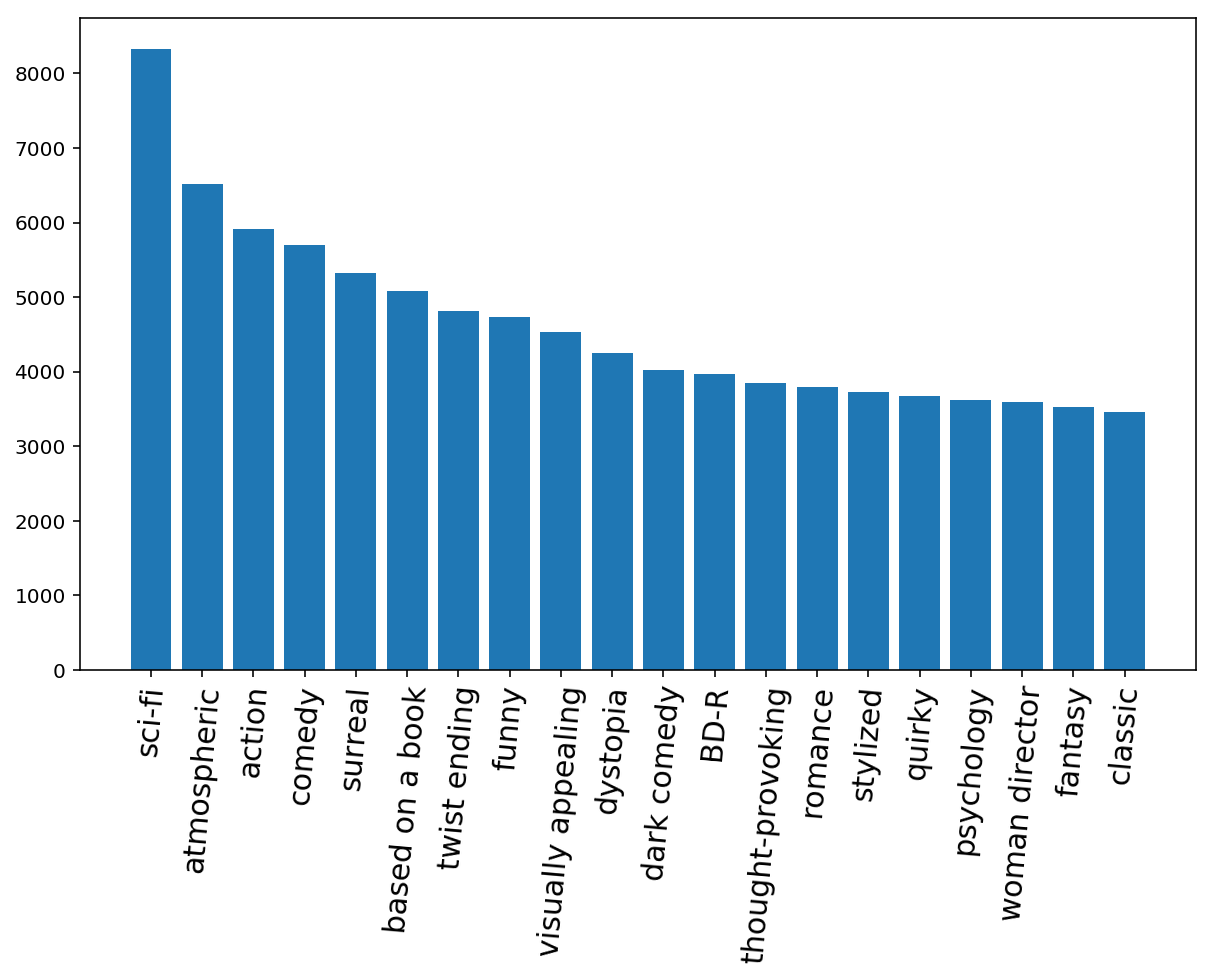

In [29]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [30]:
ratings = sc.textFile(RATINGS_PATH)
ratings.take(5)

ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))
ratings_count = ratings\
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: (a + b))

movies = sc.textFile(MOVIES_PATH)
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

res = ratings_count\
    .join(movies)\
    .sortBy(lambda key_value: int(key_value[1][0]), ascending=False)\
    .map(lambda a: (a[1][0], a[1][1][1]))\
    .take(10)

print(res)

[(81491, 'Forrest Gump (1994)'), (81482, '"Shawshank Redemption'), (79672, 'Pulp Fiction (1994)'), (74127, '"Silence of the Lambs'), (72674, '"Matrix'), (68717, 'Star Wars: Episode IV - A New Hope (1977)'), (64144, 'Jurassic Park (1993)'), (60411, "Schindler's List (1993)"), (59184, 'Braveheart (1995)'), (58773, 'Fight Club (1999)')]


### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [31]:
ratings_count = ratings\
    .filter(lambda r: int(r.rating) == 5)\
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: (a + b))

movies = sc.textFile(MOVIES_PATH)
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

res = ratings_count\
    .join(movies)\
    .sortBy(lambda key_value: int(key_value[1][0]), ascending=False)\
    .map(lambda a: (a[1][0], a[1][1][1]))\
    .take(10)

print(res)

[(39553, '"Shawshank Redemption'), (32169, 'Pulp Fiction (1994)'), (25918, 'Forrest Gump (1994)'), (25804, 'Star Wars: Episode IV - A New Hope (1977)'), (25482, '"Matrix'), (24853, "Schindler's List (1993)"), (24801, '"Silence of the Lambs'), (24418, '"Godfather'), (21585, '"Usual Suspects'), (21486, 'Fight Club (1999)')]


### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [35]:
ratings_count = ratings\
    .map(lambda r: (r.movie_id, (r.rating, 1)))\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .mapValues(lambda r: r[0] / r[1])

movies = sc.textFile(MOVIES_PATH)
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

raing_avg = ratings_count\
    .join(movies)\
    .sortBy(lambda key_value: int(key_value[1][0]), ascending=False)\
    .map(lambda a: (a[1][0], a[1][1][1]))\
    .collect()

('Red Is the Color of (2007)', 'A Man To Remember (1938)', 'The Ties That Bind (2015)', 'A Dark Place Inside', 'War Requiem (1989)', "Girls' Club (1936)", 'Homeless for the Holidays (2009)', 'Kit Carson (1940)', 'Four Mothers (1941)', 'Witchcraft 15: Blood Rose (2017)', '"Another Time', 'Panzer Chocolate (2013)', 'Fat Pizza vs Housos (2014)', 'No Postage Necessary (2018)', 'The Wind of Change (1961)', 'At Ellen’s Age (2011)', "Hell's Caretaker (2013)", 'NOFX Backstage Passport 2', 'Roxy Hunter and the Myth of the Mermaid (2008)', 'Always Worthy (2016)') (5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0)


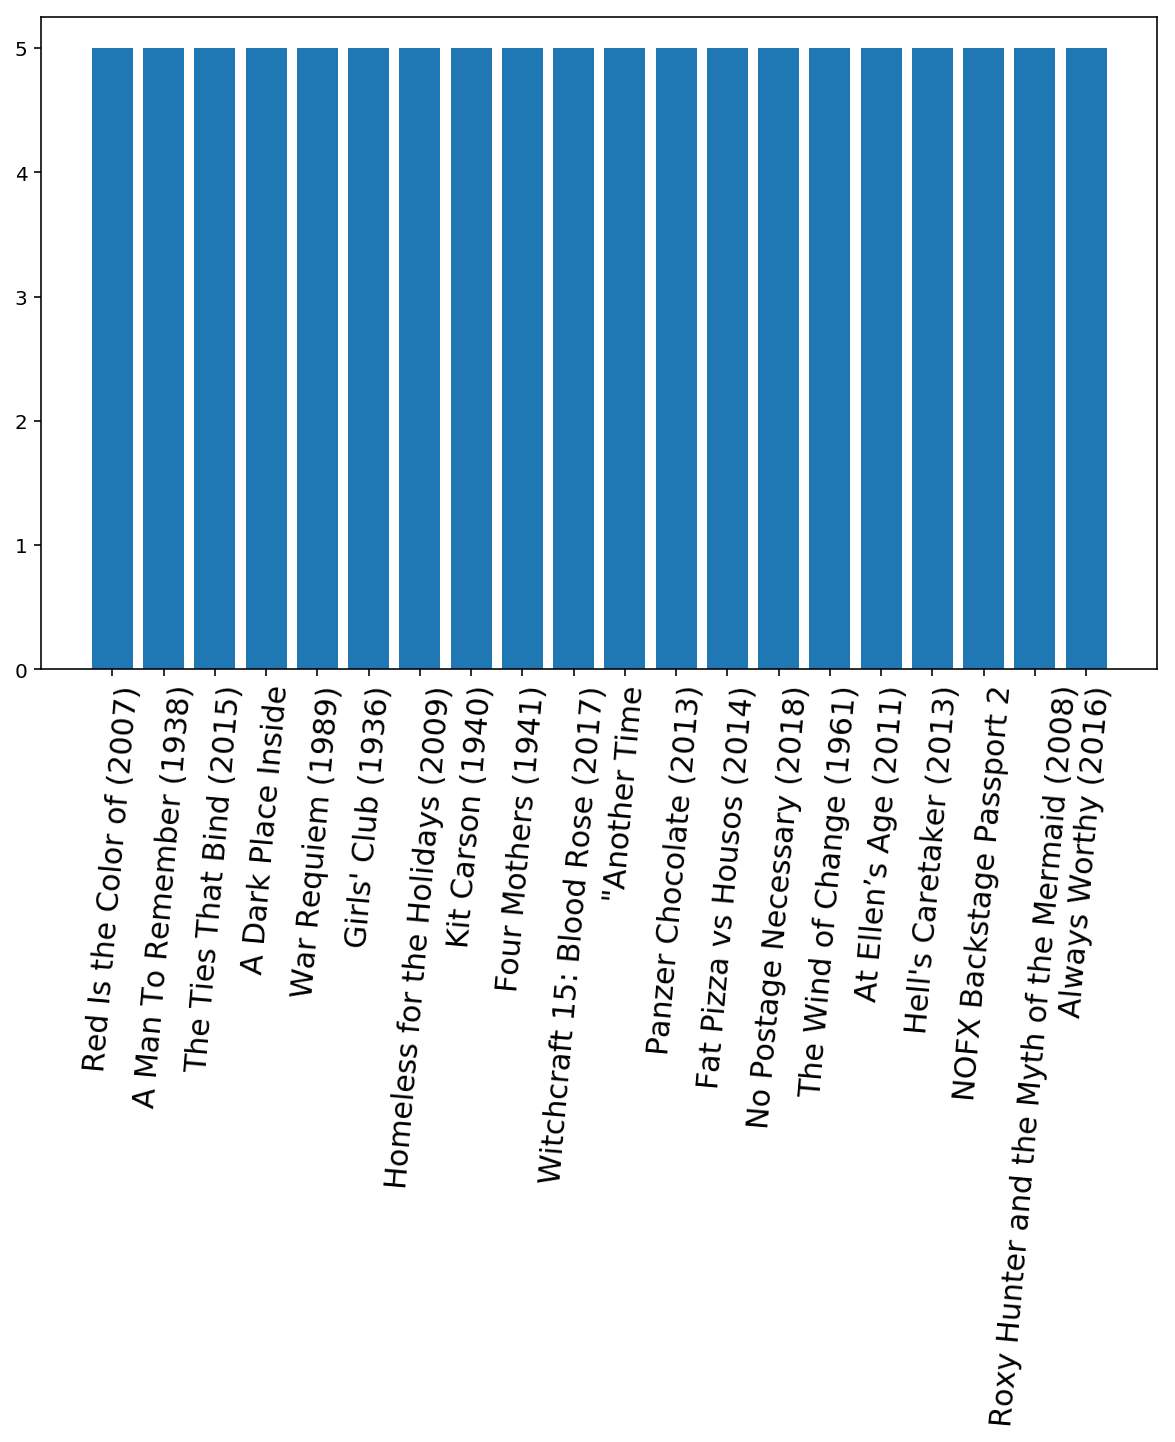

In [34]:
raing_avg = sorted(raing_avg, key=lambda r: r[0], reverse=True)

values, keys = zip(*raing_avg[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [36]:
ratings = sc.textFile(RATINGS_PATH)
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

ratings_count = ratings\
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: (a + b))

movies = sc.textFile(MOVIES_PATH)
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

res = ratings_count\
    .join(movies)\
    .sortBy(lambda key_value: int(key_value[1][0]), ascending=False)\
    .map(lambda a: (a[1][0], a[1][1][1]))\
    .collect()

print("Done!")

Done!


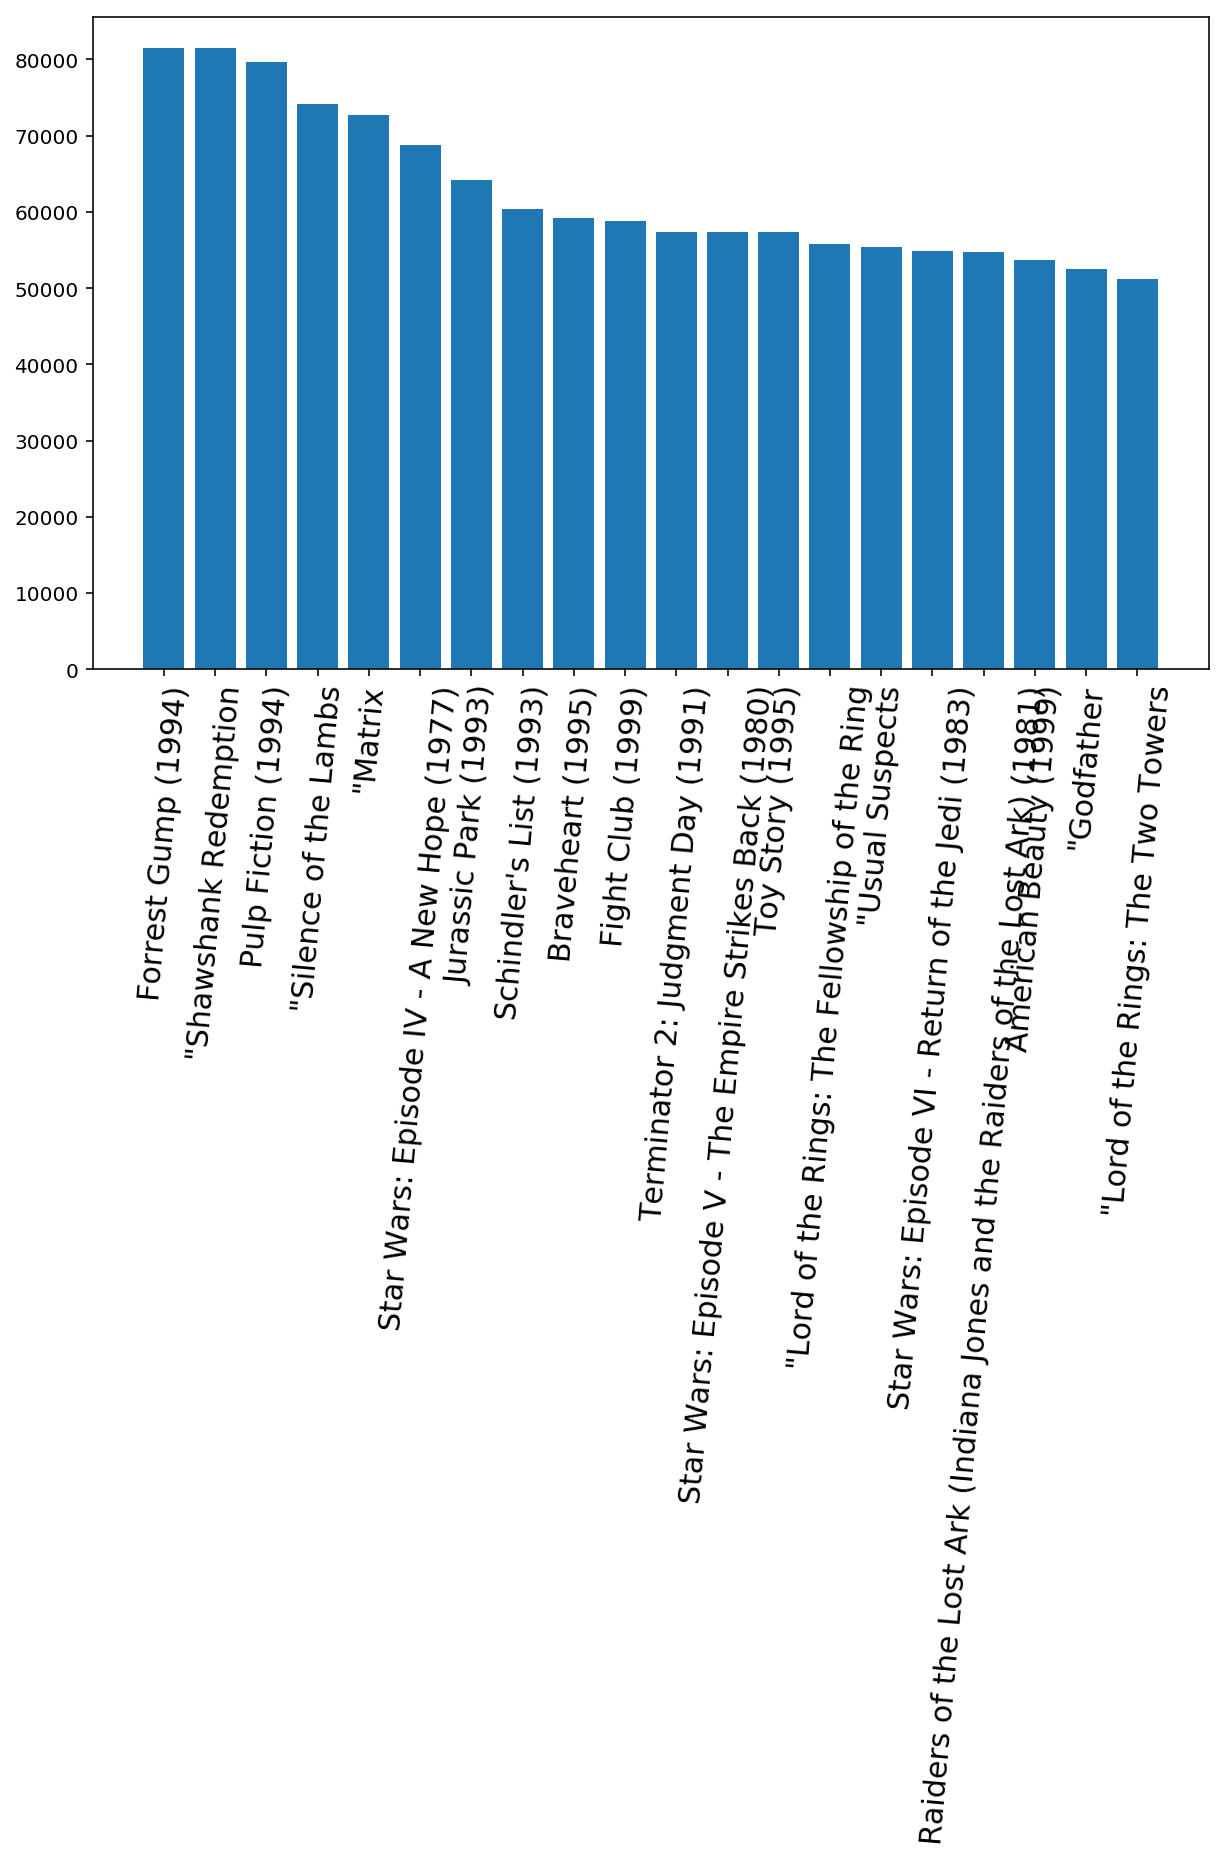

In [38]:
res = sorted(res, key=lambda r: r[0], reverse=True)

values, keys = zip(*res[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [78]:
movies = sc.textFile(MOVIES_PATH)

genres = movies\
    .map(lambda s: s.split(',')[-1])\
    .map(lambda r: (r.split('|')))\
    .reduce(lambda a, b: a + b)

genres = set(genres)
genres.remove('genres')
genres.remove('(no genres listed)')
print('Done')

Done


In [79]:
movie_prep = movies\
            .map(lambda s: s.split(',')[-1])\
            .map(lambda r: (r.split('|')))

In [80]:
%%time
keys, values = [], []
for genre in genres:
    keys.append(genre)
    val = movie_prep\
            .filter(lambda g: genre in g)\
            .count()
    values.append(val)
    
print('Done')

Done
CPU times: user 85.7 ms, sys: 26.6 ms, total: 112 ms
Wall time: 3.07 s


['Sci-Fi', 'Action', 'Comedy', 'Western', 'Romance', 'War', 'Mystery', 'Musical', 'Adventure', 'Horror', 'Drama', 'Fantasy', 'Thriller', 'IMAX', 'Crime', 'Documentary', 'Film-Noir', 'Animation', 'Children'] [3595, 7348, 16870, 1399, 7719, 1874, 2925, 1054, 4145, 5989, 25606, 2731, 8654, 195, 5319, 5605, 353, 2929, 2935]


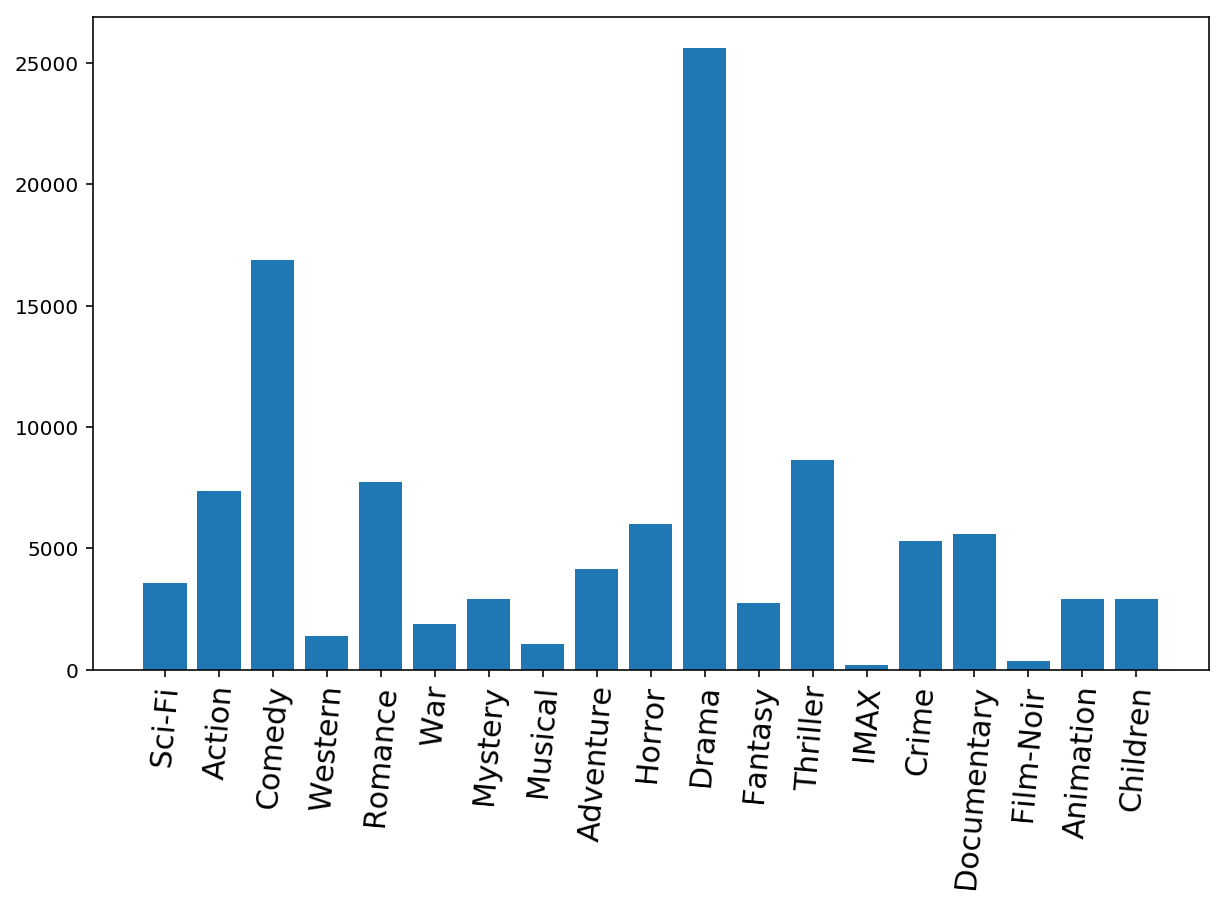

In [81]:
print(keys, values)
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

Задача 1

In [8]:
import json

TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [9]:
tmdb = sc.textFile(TMDB_PATH)
json.loads(tmdb.take(1)[0])

{'adult': False,
 'backdrop_path': '/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg',
 'belongs_to_collection': {'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg',
  'id': 10194,
  'name': 'Toy Story Collection',
  'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg'},
 'budget': 30000000,
 'casts': {'cast': [{'cast_id': 14,
    'character': 'Woody (voice)',
    'credit_id': '52fe4284c3a36847f8024f95',
    'gender': 2,
    'id': 31,
    'name': 'Tom Hanks',
    'order': 0,
    'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'},
   {'cast_id': 15,
    'character': 'Buzz Lightyear (voice)',
    'credit_id': '52fe4284c3a36847f8024f99',
    'gender': 2,
    'id': 12898,
    'name': 'Tim Allen',
    'order': 1,
    'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'},
   {'cast_id': 16,
    'character': 'Mr. Potato Head (voice)',
    'credit_id': '52fe4284c3a36847f8024f9d',
    'gender': 2,
    'id': 7167,
    'name': 'Don Rickles',
    'order': 2,
    'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'},
 

In [10]:
th = '"id": 31, "name": "Tom Hanks"'

res = tmdb\
    .filter(lambda x: th in x)\
    .map(lambda x: json.loads(x)['original_title'])\
    .collect()

print(res)

['Toy Story', 'Apollo 13', 'Forrest Gump', 'Philadelphia', 'Sleepless in Seattle', 'The Celluloid Closet', 'That Thing You Do!', 'Saving Private Ryan', "The 'Burbs", 'Splash', 'The Money Pit', 'Nothing in Common', "You've Got Mail", 'Big', 'Return with Honor', 'Toy Story 2', 'The Bonfire of the Vanities', 'The Green Mile', 'A League of Their Own', 'Volunteers', 'Bachelor Party', 'Punchline', 'Cast Away', 'Turner & Hooch', "He Knows You're Alone", 'Joe Versus the Volcano', 'Road to Perdition', 'Catch Me If You Can', 'Radio Flyer', 'Dragnet', 'The Ladykillers', 'The Terminal', 'The Man with One Red Shoe', 'The Polar Express', 'The Da Vinci Code', 'Cars', 'The Simpsons Movie', "Charlie Wilson's War", 'The Great Buck Howard', 'Angels & Demons', 'Shooting War', 'Toy Story 3', 'The Pixar Story', 'Larry Crowne', 'Extremely Loud & Incredibly Close', 'Beyond All Boundaries', 'Cloud Atlas', 'Captain Phillips', 'Toy Story of Terror!', 'Saving Mr. Banks', 'Killing Lincoln', 'Hawaiian Vacation', 'S

In [11]:
len(res)

76

Задача 2

In [44]:
def find_actors(js):
    js = json.loads(js)
    res = []
    try:
        cast = js['casts']['cast']
        for act_js in cast:
            x = [(act_js['id'], act_js['name'])]
            res += x
    except Exception:
        return res
    return res

In [47]:
%%time

movies_act = tmdb\
    .map(lambda a: find_actors(a))\
    .reduce(lambda a, b: a + b) 

[(31, 'Tom Hanks'), (12898, 'Tim Allen'), (7167, 'Don Rickles')]
CPU times: user 353 ms, sys: 60.7 ms, total: 414 ms
Wall time: 2min 44s


In [92]:
act_dict = {}
ids, actors = zip(*movies_act)
for id, actor in zip(ids, actors):
    act_dict[id] = actor

vals, keys = np.unique(ids, return_counts=True)
arr = sorted(zip(vals, keys), key=lambda x: x[1], reverse=True)
print(arr[:2])
vals, keys = zip(*arr[:10])
vals = list(map(lambda idd: "{}, {}".format(act_dict[idd], idd), vals))

vals, keys = keys, vals

[(121323, 380), (15831, 184)]


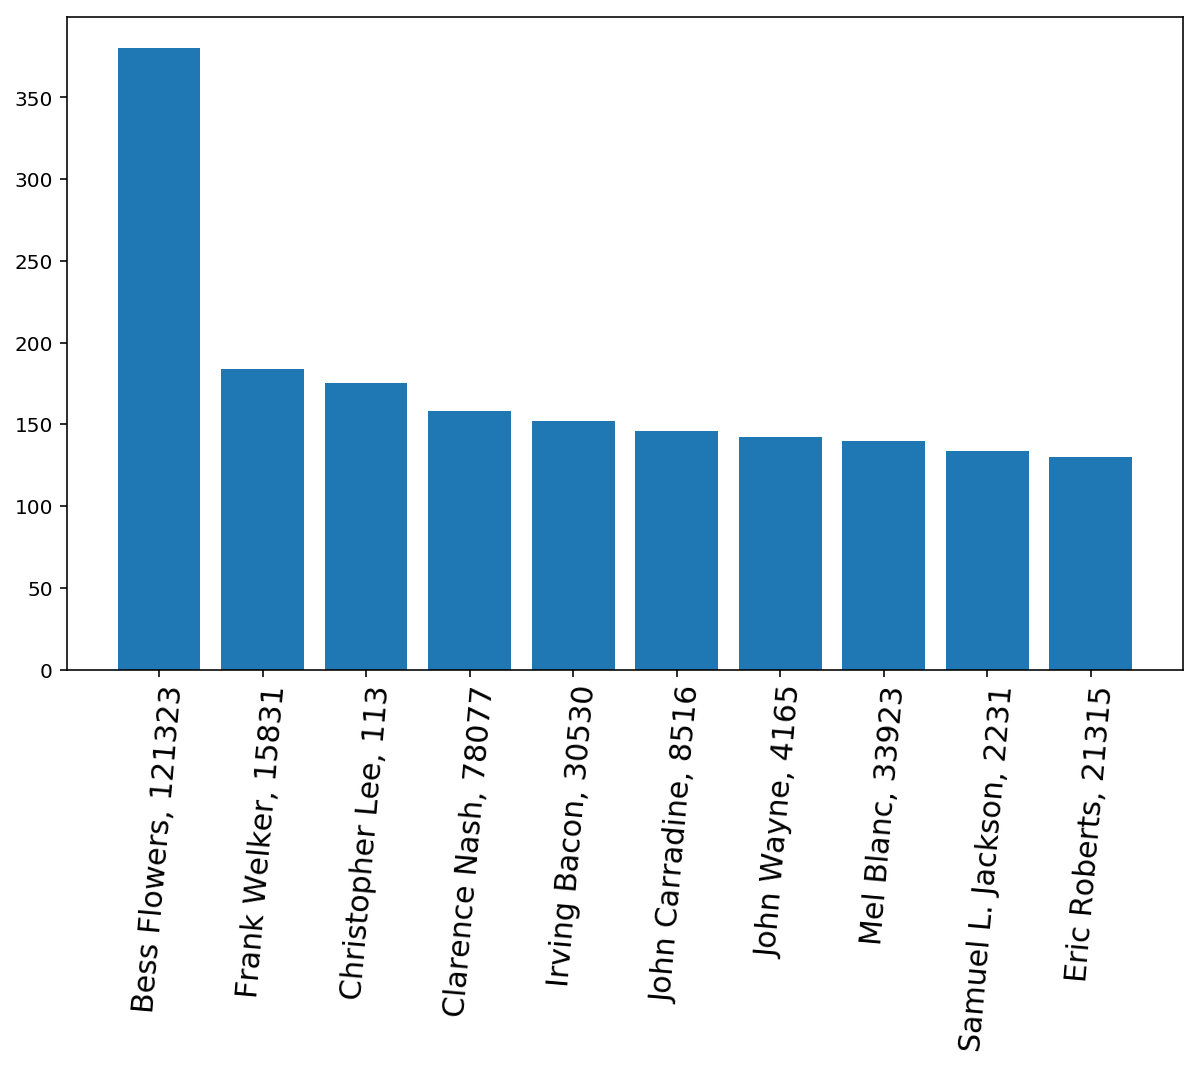

In [93]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, vals, align="center")
plt.show()

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [94]:
tmdb = sc.textFile(TMDB_PATH)

movies.take()

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy']

In [106]:
%%time

def get_gnid(s):
    tmp = s.split(',')
    return (tmp[0], tmp[-1])


def get_revenue_budget(js):
    js = json.loads(js)
    genres = []
    try:
        for genre in js['genres']:
            genres.append(genre['name'])
        return (js['id'], (js['budget'], js['revenue'], genres))
    except:
        return (-1, (1, 1, []))


    tmdb_prep = tmdb\
    .map(get_revenue_budget)\
    .filter(lambda x: x[0] != -1)

genres = ['Science Fiction',
        'Comedy',
        'Horror',
        'Mystery',
        'Family',
        'Action',
        'Animation',
        'Western',
        'War',
        'Drama',
        'Documentary',
        'Romance',
        'History',
        'Crime',
        'Fantasy',
        'Thriller',
        'TV Movie',
        'Music',
        'Adventure']

keys = []
vals = []
for genre in genres:
    tmdb_genre = tmdb_prep\
        .filter(lambda x: genre in x[1][2])
    
    revenue_mean = tmdb_genre\
        .map(lambda x: x[1][1])\
        .mean()
        
    budget_mean = tmdb_genre\
        .map(lambda x: x[1][0])\
        .mean()
    
    roi = revenue_mean / budget_mean
    
    keys.append(genre)
    vals.append(roi)

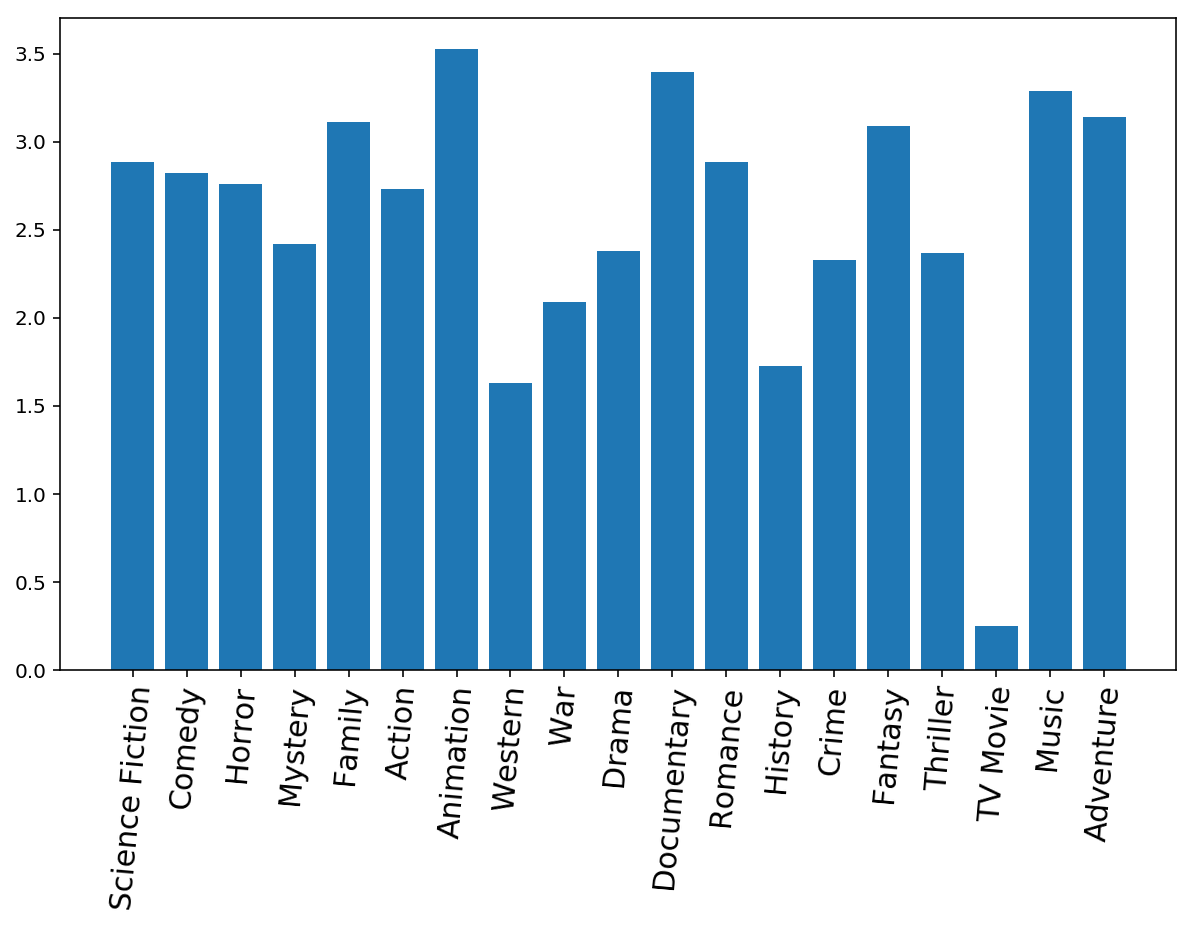

In [107]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, vals, align="center")
plt.show()